In [82]:
import pandas as pd
import numpy as np

from collections import Counter

# machine learning (sklearn) import
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay

# plotting
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set_theme()


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)


In [2]:
# Load data
data = pd.read_csv('../../data/ml_input.csv')

# Set index
data = data.set_index('pairs')
data.head()



,Unnamed: 0,hostname,phagename,infection,k3dist,k6dist,GCdiff,Homology,data
pairs,,,,,,,,,
Staphylococcus_arlettae:PG-2021_10,1,Staphylococcus_arlettae,PG-2021_10,NoInf,0.578449,0.402651,-2.742114,0,StaphStudy
Staphylococcus_aureus:PG-2021_10,2,Staphylococcus_aureus,PG-2021_10,Inf,0.616030,0.433584,-2.089694,0,StaphStudy
Staphylococcus_auricularis:PG-2021_10,3,Staphylococcus_auricularis,PG-2021_10,NoInf,0.683113,0.479903,-6.609046,0,StaphStudy
Staphylococcus_capitis:PG-2021_10,4,Staphylococcus_capitis,PG-2021_10,Inf,0.453624,0.328484,-2.156700,0,StaphStudy
Staphylococcus_caprae:PG-2021_10,5,Staphylococcus_caprae,PG-2021_10,NoInf,0.550319,0.381439,-2.849845,0,StaphStudy


In [22]:
print(data['infection'].value_counts())

NoInf    6079
Inf      2770
Name: infection, dtype: int64


In [3]:
# Select relevant rowws for machine learning
ml_data = data[['GCdiff', 'k3dist', 'k6dist', 'Homology']]

# Output
print('The dataframe is made of {} rows and {} columns!'.format(ml_data.shape[0], ml_data.shape[1]))

The dataframe is made of 8849 rows and 4 columns!


In [4]:
# Retrieve target
ml_target = data['infection']

# Replace categorical values with numbers
ml_target = ml_target.map({'NoInf' : 0, 'Inf': 1})

## (New) Determining best parameters

https://stats.stackexchange.com/questions/453221/should-i-use-gridsearchcv-on-all-of-my-data-or-just-the-training-set

https://towardsdatascience.com/machine-learning-part-18-boosting-algorithms-gradient-boosting-in-python-ef5ae6965be4

In [7]:
# define key parameters
train_size = 0.7
test_size = 1 - train_size
bootstrap = 100

param_grid = {'learning_rate': [0.1, 0.25, 0.5, 0.75, 1],
              'loss': ['log_loss', 'exponential'],
              'max_depth': [5, 7, 10, 12, 15]}

grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=ShuffleSplit(), n_jobs=7, return_train_score=True)


Testing downsamples methods before using in bootstrap analysis.

In [34]:
noninf_messages = data[data['infection']=='NoInf']
inf_messages = data[data['infection']=='Inf']

# define targetted imbalance (60/40 ratio)
ntarget_samples = int(len(inf_messages) + 0.50 * len(inf_messages))
print(ntarget_samples)

print(noninf_messages.shape)
print(inf_messages.shape)

4155
(6079, 9)
(2770, 9)


In [41]:
ROC_disp = None
F1_disp = None

best_rate = []
best_loss = []
best_depth = []

noninf_messages = data[data['infection']=='NoInf']
inf_messages = data[data['infection']=='Inf']

for i in range(0, bootstrap):
    print(f'bootstrap number {i}')

    # fix imbalance
    noninf_downsample = resample(noninf_messages, replace=True, n_samples=ntarget_samples)
    boot_data = pd.concat([noninf_downsample, inf_messages])
    print(boot_data['infection'].value_counts())

    # prep input data
    ml_data = boot_data[['GCdiff', 'k3dist', 'k6dist', 'Homology']]
    ml_target = boot_data['infection']
    ml_target = ml_target.map({'NoInf' : 0, 'Inf': 1})

    # split data
    X_train, X_test, y_train, y_test = train_test_split(ml_data, ml_target, random_state=0, test_size=test_size, train_size=train_size)
    
    # grid search
    grid_search.fit(X_train, y_train)

    print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))
    print("Best parameters: {}".format(grid_search.best_params_))
    print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
    print("Best estimator:\n{}".format(grid_search.best_estimator_))

    # extract best parameter to retrain model one more time
    best_rate.append(grid_search.best_params_['learning_rate'])
    best_loss.append(grid_search.best_params_['loss'])
    best_depth.append(grid_search.best_params_['max_depth'])



bootstrap number 0
NoInf    4155
Inf      2770
Name: infection, dtype: int64
Test set score: 0.88
Best parameters: {'learning_rate': 1, 'loss': 'exponential', 'max_depth': 15}
Best cross-validation score: 0.88
Best estimator:
GradientBoostingClassifier(learning_rate=1, loss='exponential', max_depth=15)
bootstrap number 1
NoInf    4155
Inf      2770
Name: infection, dtype: int64
Test set score: 0.88
Best parameters: {'learning_rate': 1, 'loss': 'exponential', 'max_depth': 12}
Best cross-validation score: 0.88
Best estimator:
GradientBoostingClassifier(learning_rate=1, loss='exponential', max_depth=12)
bootstrap number 2
NoInf    4155
Inf      2770
Name: infection, dtype: int64
Test set score: 0.87
Best parameters: {'learning_rate': 0.5, 'loss': 'log_loss', 'max_depth': 15}
Best cross-validation score: 0.88
Best estimator:
GradientBoostingClassifier(learning_rate=0.5, max_depth=15)
bootstrap number 3
NoInf    4155
Inf      2770
Name: infection, dtype: int64
Test set score: 0.88
Best para

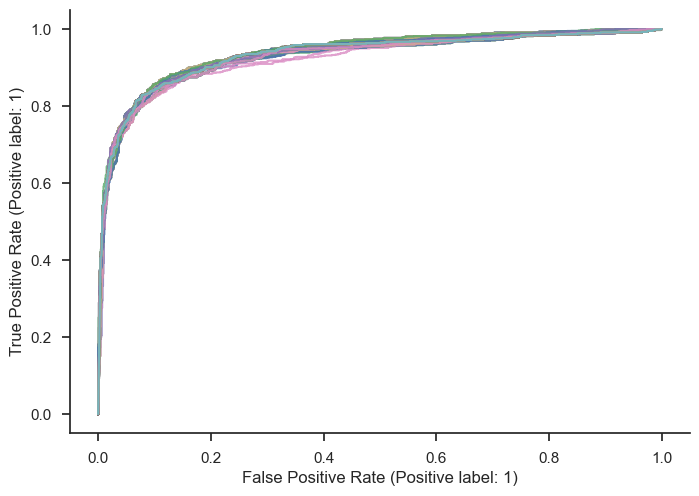

In [93]:
for i in range(0, bootstrap):

    depth = best_depth[i]
    rate = best_rate[i]
    loss = best_loss[i]

    gbrt = GradientBoostingClassifier(random_state=0, max_depth=depth, learning_rate=rate, loss=loss)
    gbrt.fit(X_train, y_train)

    # ROC plot
    if not ROC_disp:
        ROC_disp = RocCurveDisplay.from_estimator(gbrt, X_test, y_test)
    else:
        ax = plt.gca()
        new_disp = RocCurveDisplay.from_estimator(gbrt, X_test, y_test, ax=ax, alpha=0.8)
        ROC_disp.plot(ax=ax, alpha=0.8)


ax.get_legend().remove()
plt.show()

In [84]:
from sklearn.metrics import roc_auc_score

In [86]:
roc_scores = []
for i in range(0, bootstrap):

    depth = best_depth[i]
    rate = best_rate[i]
    loss = best_loss[i]

    gbrt = GradientBoostingClassifier(random_state=0, max_depth=depth, learning_rate=rate, loss=loss)
    gbrt.fit(X_train, y_train)

    roc_scores.append(roc_auc_score(y_test, gbrt.decision_function(X_test)))

In [92]:
print(np.average(roc_scores))
print(np.std(roc_scores))

0.9344285829377124
0.003733569328165446


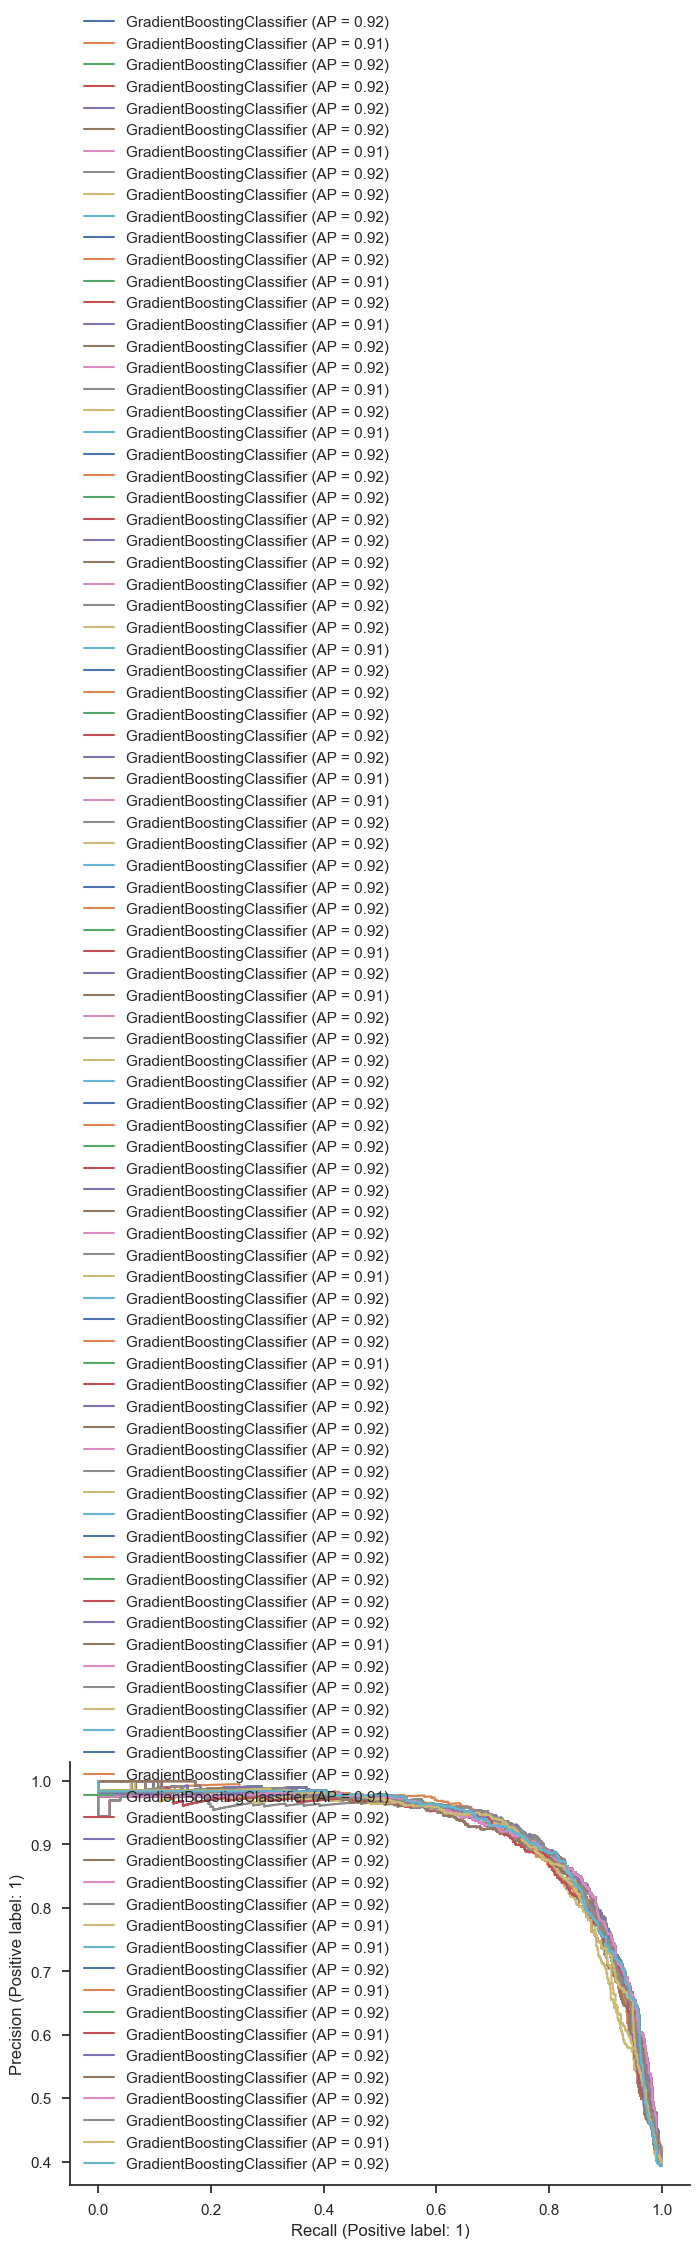

In [101]:
F1_disp = plt.plot()

for i in range(0, bootstrap):

    depth = best_depth[i]
    rate = best_rate[i]
    loss = best_loss[i]

    gbrt = GradientBoostingClassifier(random_state=0, max_depth=depth, learning_rate=rate, loss=loss)
    gbrt.fit(X_train, y_train)

    # F1 plot
    F1_disp = PrecisionRecallDisplay.from_estimator(gbrt, X_test, y_test, ax=plt.gca())

plt.savefig('F1_100curves.pdf', format='pdf')

Determining best performing parameters across all runs. 

In [80]:
print(Counter(best_depth))
print(Counter(best_rate))
print(Counter(best_loss))

Counter({15: 73, 12: 24, 10: 3})
Counter({0.75: 41, 1: 37, 0.5: 18, 0.25: 2, 0.1: 2})
Counter({'exponential': 58, 'log_loss': 42})


## Grid of best hyper parameters comparison


In [60]:
param_grid = {'learning_rate': [0.1, 0.2, 0.3, 0.5, 0.75, 0.8, .85, .9, 1],
              'loss': ['log_loss', 'exponential'],
              'max_depth': [3, 5, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25]}

grid_search = GridSearchCV(GradientBoostingClassifier(), param_grid, cv=ShuffleSplit(), n_jobs=7, return_train_score=True)

# split data into train+validation and test set
X_train, X_test, y_train, y_test = train_test_split(ml_data, ml_target, random_state=0, test_size=test_size, train_size=train_size)

grid_search.fit(X_train, y_train)

print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))

print("Best parameters: {}".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Test set score: 0.89
Best parameters: {'learning_rate': 0.9, 'loss': 'exponential', 'max_depth': 16}
Best cross-validation score: 0.87


In [61]:
print("Best estimator:\n{}".format(grid_search.best_estimator_))

Best estimator:
GradientBoostingClassifier(learning_rate=0.9, loss='exponential', max_depth=16)


In [62]:
# convert to DataFrame
results = pd.DataFrame(grid_search.cv_results_)
# show the first 5 rows
display(results.tail())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_loss,param_max_depth,params,split0_test_score,split1_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
283,1.762733,0.094583,0.003265,0.000069,1,exponential,17,"{'learning_rate': 1, 'loss': 'exponential', 'm...",0.880412,0.886598,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
284,1.630233,0.051365,0.003339,0.000283,1,exponential,18,"{'learning_rate': 1, 'loss': 'exponential', 'm...",0.861856,0.874227,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
285,1.502515,0.055843,0.003109,0.000065,1,exponential,19,"{'learning_rate': 1, 'loss': 'exponential', 'm...",0.878351,0.884536,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
286,1.286705,0.121963,0.002896,0.000161,1,exponential,20,"{'learning_rate': 1, 'loss': 'exponential', 'm...",0.880412,0.859794,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
287,0.552513,0.009665,0.001904,0.000329,1,exponential,25,"{'learning_rate': 1, 'loss': 'exponential', 'm...",0.851546,0.837113,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [63]:
scores_heatmap = results.pivot(index='param_learning_rate', columns=['param_max_depth', 'param_loss'], values='mean_test_score')
scores_heatmap.head()


/var/folders/yy/x1x_rtqj13l_9jplp1l2hxgw0000gn/T/ipykernel_56652/3435042909.py:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  scores_heatmap = results.pivot(index='param_learning_rate', columns=['param_max_depth', 'param_loss'], values='mean_test_score')


param_max_depth,3,5,7,8,9,10,12,13,14,15,...,12,13,14,15,16,17,18,19,20,25
param_loss,log_loss,log_loss,log_loss,log_loss,log_loss,log_loss,log_loss,log_loss,log_loss,log_loss,...,exponential,exponential,exponential,exponential,exponential,exponential,exponential,exponential,exponential,exponential
param_learning_rate,,,,,,,,,,,,,,,,,,,,,
0.10,0.804742,0.844536,0.854021,0.858969,0.865979,0.860412,0.862062,0.862887,0.858557,0.858351,...,0.862887,0.860825,0.861443,0.863299,0.861237,0.859588,0.860825,0.851340,0.850928,0.840825
0.20,0.821031,0.847629,0.860000,0.862474,0.863505,0.863299,0.862268,0.865979,0.860206,0.863505,...,0.863918,0.861237,0.862680,0.860619,0.865979,0.864742,0.863711,0.862680,0.855876,0.839794
0.30,0.825361,0.850928,0.855876,0.856701,0.862268,0.864330,0.863299,0.865567,0.866392,0.866392,...,0.862474,0.863093,0.861031,0.865979,0.868866,0.865773,0.863711,0.864124,0.859794,0.840619
0.50,0.828866,0.849485,0.852990,0.857526,0.861856,0.865773,0.864742,0.867216,0.865361,0.865567,...,0.868866,0.866598,0.867216,0.870928,0.865979,0.872165,0.869691,0.867423,0.858144,0.840619
0.75,0.832577,0.840412,0.853814,0.857938,0.864124,0.865567,0.865773,0.867423,0.867010,0.869485,...,0.864536,0.866392,0.869278,0.869691,0.872165,0.868247,0.869485,0.870928,0.860206,0.842680


[Text(0.5, 167.76388888888883, 'Max depth and loss parameters'),
 Text(698.3888888888889, 0.5, 'Learning rate')]

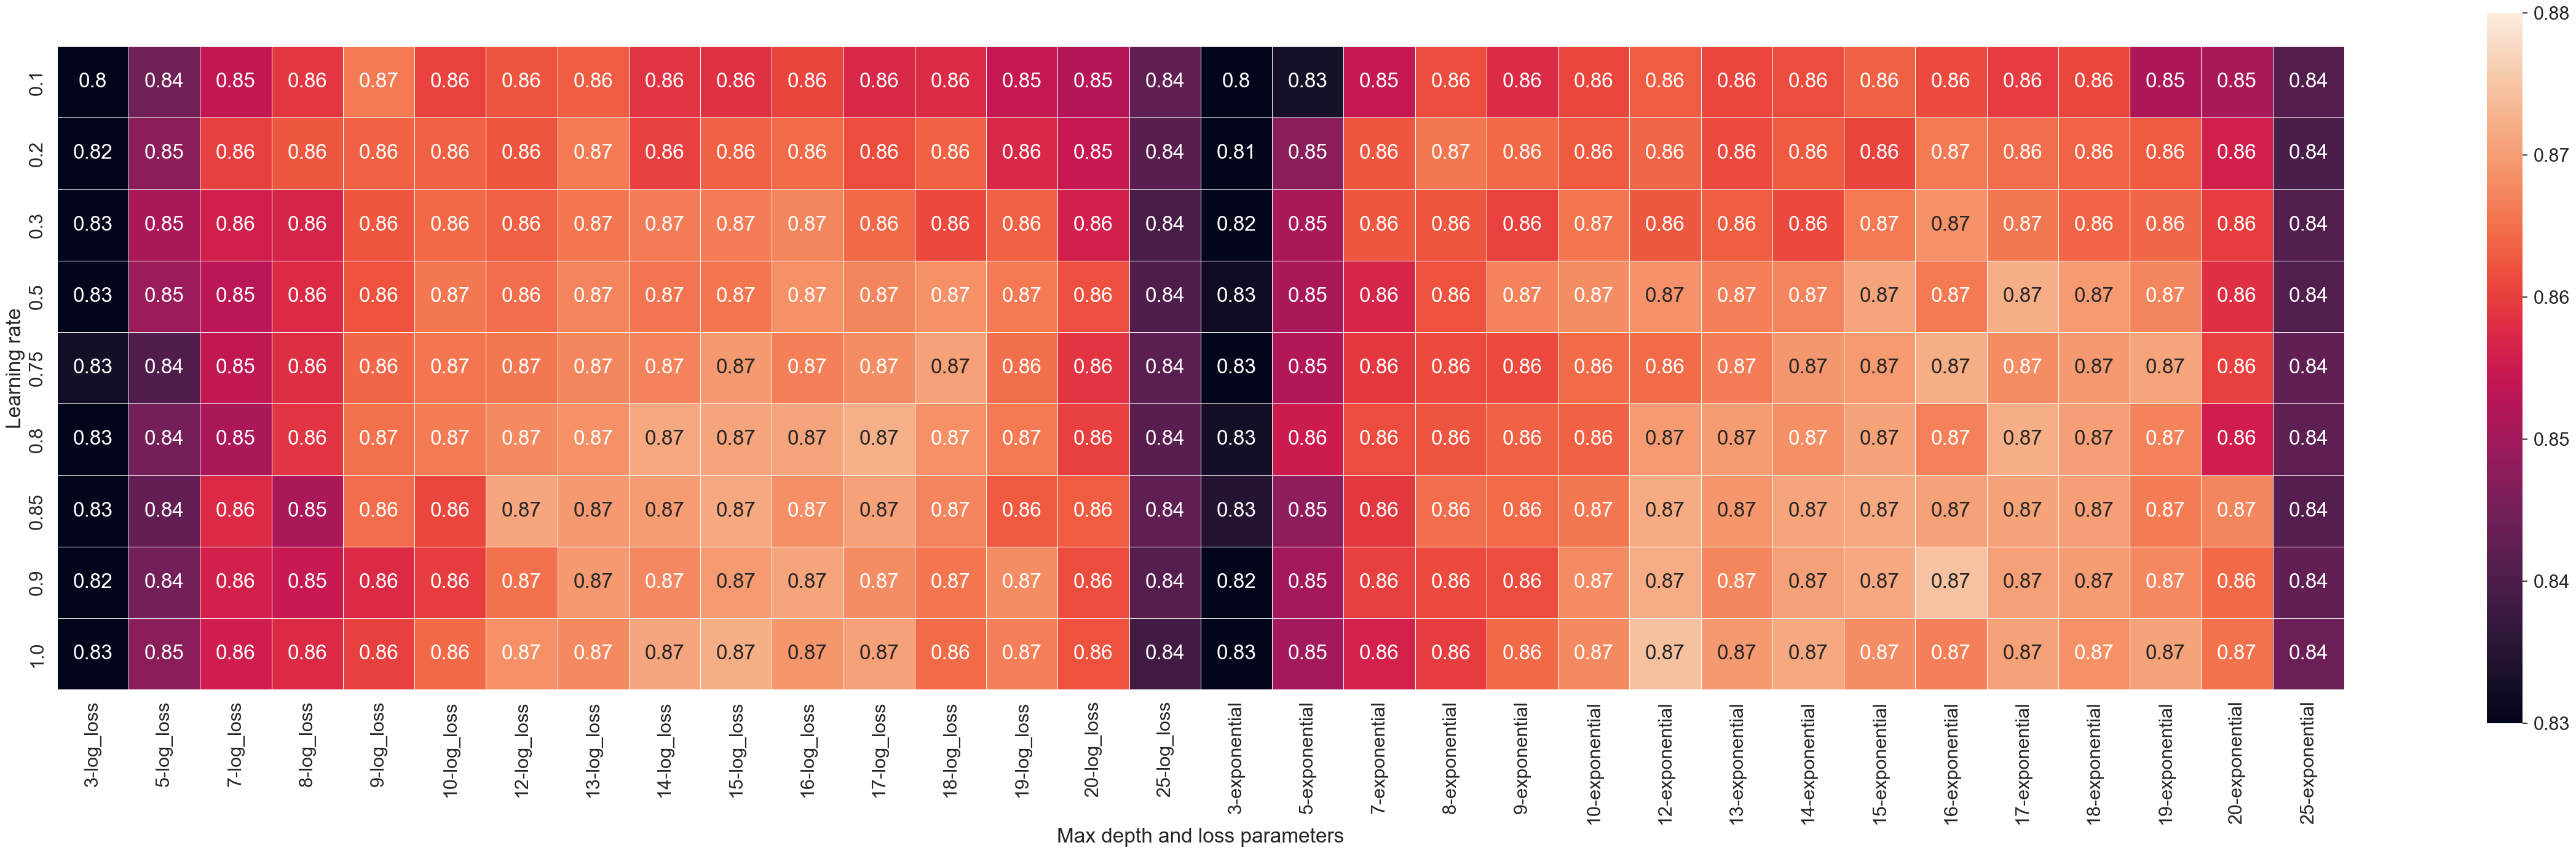

In [76]:
f, ax = plt.subplots(figsize=(60, 15))
sns.set(font_scale=2)
sns.heatmap(scores_heatmap, annot=True, linewidths=0.5, ax=ax, square=True, vmin=0.83, vmax=0.88)
ax.set(xlabel='Max depth and loss parameters', ylabel='Learning rate')

## (Old) Determining best parameters


In [8]:
# boostraps values
jter = 100
iter = 100

# test and train sizes
training_size = 0.7
testing_size = 1 - training_size

# parameters to try
learning_rates = [0.1, 0.2, 0.3, 0.5, 0.75]
loss = ['log_loss', 'exponential']
max_depth = [3, 5, 6, 7, 8]

Setup the cross validation.

In [9]:
# split data into train+validation and test set
X_trainval, X_test, y_trainval, y_test = train_test_split(ml_data, ml_target, random_state=0, test_size=testing_size, train_size=training_size)

Now let's train many many and many more models to determine the best parameters. This is also called a grid search!

In [10]:
best_score = 0

for rate in learning_rates:
    for losstype in loss:
        for depth in max_depth:
            #print(rate, losstype, depth)
            # train model
            gbrt = GradientBoostingClassifier(random_state=10, max_depth=depth, learning_rate=rate, loss=losstype)
            scores = cross_val_score(gbrt, X_trainval, y_trainval, cv=5)
            print(np.mean(scores))
            score = np.mean(scores)
            if score > best_score:
                best_score = score
                best_parameters = {'learning_rate': rate, 'loss': losstype, 'max_depth': depth}


0.8291898594546385
0.8490479710955601
0.8553440225519303
0.8619636973378656
0.8619635669497393
0.8259614494465677
0.839039117741782
0.850985799429161
0.8601878110571738
0.8595423898318124
0.841782744696137
0.8561522985470852
0.856313849435615
0.861479044672276
0.8590579979424755
0.8306417312413862
0.8550218334917549
0.8605119559392443
0.8642241058960207
0.8656771511759054
0.8421049337563125
0.8543752387732564
0.8530843963225333
0.8577672858798786
0.860025869004265
0.8362927526367738
0.8567973286080676
0.8595440848774547
0.8630936408406905
0.8655149483467438
0.8358097950168265
0.8411360195895121
0.8505019290923291
0.8524380623802875
0.8566368208245484
0.8419452083015511
0.860510260893602
0.8580893445519278
0.8592190272784999
0.8674535590091024
0.8379090438508306
0.8390382050248976
0.839522336137982
0.852923106210256
0.8538929330939407
0.8406522796408067
0.8513090315943469
0.8587358088822998
0.8630941623931958
0.8639003521783293
